# II. Camera model and homographies

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

from lib import box3d

In [9]:
def get_distorted(r, distortion_coefficients):
    """Return p(1 + dr(p))."""
    k3, k5, k7 = distortion_coefficients
    n = r[0, :] ** 2 + r[1, :] ** 2
    dr = k3 * n ** 2 + k5 * n ** 4 + k7 * n ** 6
    return r * (1 + dr)


def projectpoints(K, R, t, Q, distortion_coeff=[0, 0, 0]):
    """Return the projected points as a 2xn matrix."""
    _, n = Q.shape
    Q = np.vstack([Q, np.ones(n)])
    T = np.vstack([np.hstack([R, t])])

    r = T @ Q
    r = r[:2, :] / r[2, :]
    dist = get_distorted(r, distortion_coeff)
    P = K @ np.concatenate([dist, np.ones([1, n])], axis=0)
    return P

In [10]:
f = 600
alpha = 1
beta = 0
dx = 400
dy = 400

K = np.array([[f, beta * f, dx], [0, alpha * f, dy], [0, 0, 1]])
R = np.eye(3)
t = np.array([[0, 0.2, 1.5]]).T

Q = box3d(16)

### 2.1 Without distortion

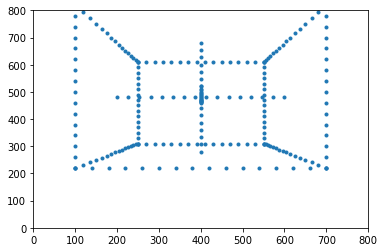

In [11]:
p2d = projectpoints(K, R, t, Q)

plt.plot(p2d[0], p2d[1], ".")
plt.xlim(0, 2 * dx)
plt.ylim(0, 2 * dy);

### 2.2 With distortion

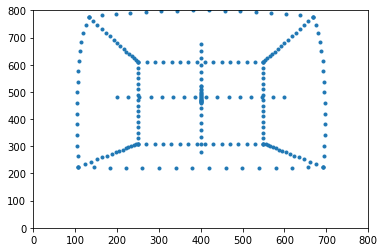

In [13]:
distortion = [-0.2, 0, 0]
p2d = projectpoints(K, R, t, Q, distortion_coeff=distortion)
  
plt.plot(p2d[0], p2d[1], ".")
plt.xlim(0, 2 * dx)
plt.ylim(0, 2 * dy);

### 2.3 GoPro

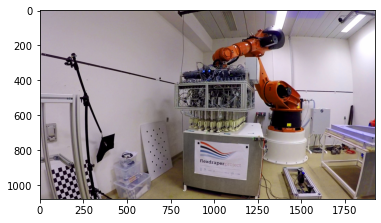

In [14]:
im = cv2.imread("gopro_robot.jpg")
b, g, r = cv2.split(im)
im = cv2.merge([r, g, b])

plt.imshow(im);

In [15]:
(h, w, d) = im.shape
f = 0.455732 * w
dx = h // 2
dy = w // 2
k3 = -0.245031
k5 = 0.071524
k7 = -0.00994978
distortion = np.array([k3, k5, k7])

K = np.array([[f, beta * f, dx], [0, alpha * f, dy], [0, 0, 1]])
K.astype(int)

array([[875,   0, 540],
       [  0, 875, 960],
       [  0,   0,   1]])

### 2.4 Undistort the image
# I only get the correct result if I halve the distortion

In [101]:
# f = K[0][0]
    
# Ap = f * np.eye(3)
# Ap[2, 2] = 1
    
# Aq = K
# Aq[:2, :2] /= f

def undistortImage(Image, K, distortion_coeff):
    """
    Parameters
    ----------
    Image:
        image
    K:
        camera matrix
    distortion_coeff:
        distortion coefficients

    Return
    ------
    An undistorted version of the image
    """
    h, w, d = Image.shape
    
    grid = np.ones([h * w, 3], dtype=int)
    columns, rows = np.meshgrid(np.arange(0, w), np.arange(0, h))
    grid[:, 0], grid[:, 1] = rows.flatten(), columns.flatten()

    grid = np.linalg.inv(K) @ grid.T
    grid /= grid[2]
    grid = get_distorted(grid, distortion_coeff)
    grid = (K @ grid).T
    
    grid = grid.reshape(h, w, 3)[:, :, :2].astype(int)
    
    points = (np.arange(0, h), np.arange(0, w))
    I_undistorted = np.zeros(Image.shape)
    for i in range(d):
        I = Image[:, :, i]
        interpolating_function = RegularGridInterpolator(
            points,
            values=I,
            method="nearest",
            bounds_error=False,
            fill_value=0
        )
        I_undistorted[:, :, i] = interpolating_function(grid)
    return I_undistorted.astype(int)

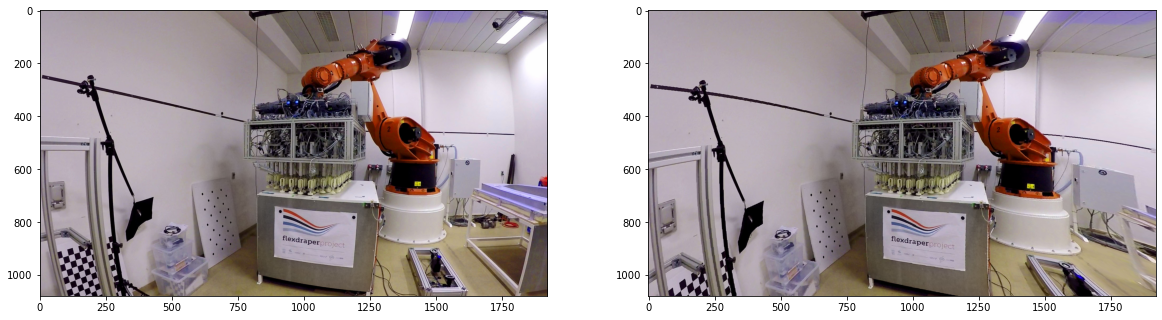

In [104]:
J = undistortImage(im, K, distortion/2)

fig, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].imshow(im)
ax[1].imshow(J);

## Homographies

### 2.5 Apply homography matrix

In [10]:
set1 = np.array([
    [1, 0, 2, 2],
    [1, 3, 3, 4],
    [1, 1, 1, 1],
])

H = np.array([
    [-2,  0, 1],
    [ 1, -2, 0],
    [ 0,  0, 3],
])

set2 = H @ set1
set2 = set2 / set2[2, :]
set2

array([[-0.33333333,  0.33333333, -1.        , -1.        ],
       [-0.33333333, -2.        , -1.33333333, -2.        ],
       [ 1.        ,  1.        ,  1.        ,  1.        ]])

### 2.6 Estimate homography matrix

In [49]:
def hest(q1, q2):
    """
    Parameters
    ----------
    q1, q2: 3 x n numpy arrays
        sets of points
    Return
    ------
    H: 3x3 numpy array
        Estimated homography matrix using the linear algorithm.
    """
    B = get_B(q1, q2)
    U, S, VT = np.linalg.svd(B.T @ B)
    H = np.reshape(VT[-1], (3, 3), 'F')
    return H / H[2, 2]

def get_B(q1, q2):
    """
    Parameters
    ----------
    q1, q2: 3 x n numpy arrays
        sets of points
    """
    B = B_i(q1, q2, 0)
    for i in range(1, len(q1[0])):
        B = np.vstack((B, B_i(q1, q2, i)))
    return B

def B_i(q1, q2, i):
    return np.kron(
            q2[:,i],
            np.array([
                [ 0       , -1       ,  q1[1, i]],
                [ 1       ,  0       , -q1[0, i]],
                [-q1[1, i],  q1[0, i],  0       ],
            ])
        )
    

In [50]:
np.rint(H[2, 2] * hest(set2, set1)) == H

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

## 2.7

In [69]:
def normalize2d(Q):
    """Return the points normalised.

    The mean of Tq is [0, 0] and the standard deviation is [1, 1].

    Parameter
    ---------
    Q: 2 x n or 3 x n numpy array
        set of points to normalise.
    Return
    ------
    Q: 3 x n numpy array
        set of points to normalise.
    """
    d, n = Q.shape
    if d == 2:
        Q = np.vstack(Q, np.ones(n))

    mean = np.mean(Q, axis=1)
    std = np.std(Q, axis=1)

    T = np.array([
        [1 / std[0], 0         , - mean[0] / std[0]],
        [0         , 1 / std[1], - mean[1] / std[1]],
        [0         , 0,            1               ],
    ])
    TQ = T @ Q
    return TQ / TQ[2]

In [72]:
np.std(normalize2d(set1), axis=1)

array([1., 1., 0.])

### 2.8 Use the normalisation in hest: modified 2.6

### 2.9 Estimation of the homogra

# Old

In [307]:
n = im.shape[0]
m = im.shape[1]

points = (np.arange(0, n), np.arange(0, m))

I = im[:, :, 2]
interpolating_function = RegularGridInterpolator(
    points,
    values=I,
    method="nearest",
    bounds_error=False,
    fill_value=0
)

# indices = coordinates
# make homogeneous
# apply K-1
# apply distortion

grid = np.ones([n * m, 3], dtype=int)
columns, rows = np.meshgrid(np.arange(0, m), np.arange(0, n))
grid[:, 0], grid[:, 1] = rows.flatten(), columns.flatten()
grid = np.linalg.inv(K) @ grid.T
grid = projectpoints(K, R, t, grid.T, distortion)


grid = grid.reshape(n, m, 3)[:, :, :2].astype(int)

In [139]:
grid = np.ones([n, 3], dtype=int)
x, y = np.meshgrid(np.arange(0, I.shape[1]), np.arange(0, I.shape[0]))
grid[:, 1], grid[:, 0] = x.flatten(), y.flatten()
grid = (np.linalg.inv(K) @ grid.T).T

distorted_grid = grid
# distorted_grid = grid[:, :3]  #get_distorted(grid[:, :2], distortion)
# distorted_grid = K @ (np.concatenate([distorted_grid, np.ones([n, 1])], axis=1)).T
# distorted_grid = distorted_grid[:, :] / distorted_grid[2, :]
distorted_grid = distorted_grid.reshape(I.shape[0], I.shape[1], 3)#.astype(int)

new_grid = grid[:, :2].reshape(I.shape[0], I.shape[1], 2)

fig, ax = plt.subplots(1, 2, figsize=(20,12))
ax[0].imshow(I)
ax[1].imshow(interpolating_function(new_grid));

ValueError: could not broadcast input array from shape (2073600,) into shape (1080,)

In [171]:
h, w, d = Image.shape
points = (np.arange(0, h), np.arange(0, w))

grid = np.ones([h, w, 2], dtype=int)
columns, rows = np.meshgrid(np.arange(0, w), np.arange(0, h))
grid[:, :, 0], grid[:, :, 1] = rows, columns

In [172]:
grid = np.ones([h * w, 2], dtype=int)
columns, rows = np.meshgrid(np.arange(0, w), np.arange(0, h))
grid[:, 0], grid[:, 1] = rows.flatten(), columns.flatten()
grid = grid.reshape(h, w, 2)

In [173]:
grid = np.ones([h * w, 3], dtype=int)
columns, rows = np.meshgrid(np.arange(0, w), np.arange(0, h))
grid[:, 0], grid[:, 1] = rows.flatten(), columns.flatten()
grid = grid.reshape(h, w, 3)[:, :, :2]

In [174]:
grid = np.ones([h * w, 3], dtype=int)
columns, rows = np.meshgrid(np.arange(0, w), np.arange(0, h))
grid[:, 0], grid[:, 1] = rows.flatten(), columns.flatten()

grid = np.linalg.inv(K) @ grid.T
grid = (K @ grid).T

grid = grid.reshape(h, w, 3)[:, :, :2].astype(int)

In [223]:
grid = np.ones([h * w, 3], dtype=int)
columns, rows = np.meshgrid(np.arange(0, w), np.arange(0, h))
grid[:, 0], grid[:, 1] = rows.flatten(), columns.flatten()

grid = np.linalg.inv(K) @ grid.T
grid /= grid[2]
grid = get_distorted(grid, distortion)
grid = (K @ grid).T

grid = grid.reshape(h, w, 3)[:, :, :2].astype(int)